
# Model Visualizations and Heatmaps
This notebook highlights the trained xG CoreAI models, the leagues they cover, and how shot geometry maps to real goals.


## Section 1: Setup Environment and Dependencies
Import pandas, matplotlib, seaborn, and plotly, and configure inline plotting so the notebook renders clean visuals.

In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import mplsoccer as mplsoccer
from mplsoccer import Pitch

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set_theme()
print('Setup complete with pandas, matplotlib, seaborn, and plotly')

Setup complete with pandas, matplotlib, seaborn, and plotly


## Section 2: Load and Preprocess Model Outputs
Read the manifest metadata together with the consolidated shot data so we can analyze model metrics alongside actual shot outcomes.

In [43]:
manifest_path = Path('models/manifest.json')
shots_path = Path('Data/processed/shots_final.csv')

manifest = pd.read_json(manifest_path).T.reset_index().rename(columns={'index': 'league_key'})
manifest['rows'] = pd.to_numeric(manifest['rows'], errors='coerce')
manifest['trained_at'] = pd.to_datetime(manifest['trained_at'])
manifest = manifest[manifest['rows'].notna()].sort_values('trained_at')

shots_columns = ['start_x', 'start_y', 'is_goal', 'distance', 'visible_angle', 'minute', 'competition_name']
shots = pd.read_csv(shots_path, usecols=shots_columns)
shots = shots.dropna(subset=['start_x', 'start_y'])
print('Loaded', len(manifest), 'league models and', len(shots), 'shots')

Loaded 18 league models and 88023 shots


## Section 3: Generate Model Comparison Heatmaps
Seaborn heatmaps reveal how our per-league metrics correlate and where shot outcomes cluster on the pitch.

Text(0.5, 1.0, 'Goal Conversion Rate per Zone')

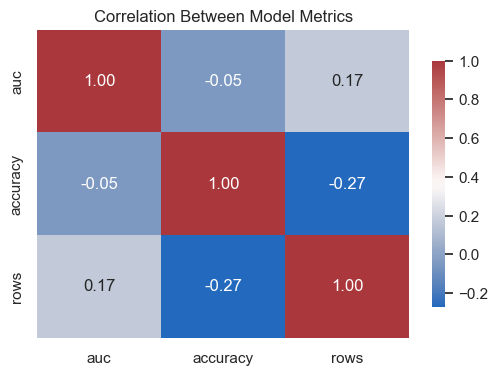

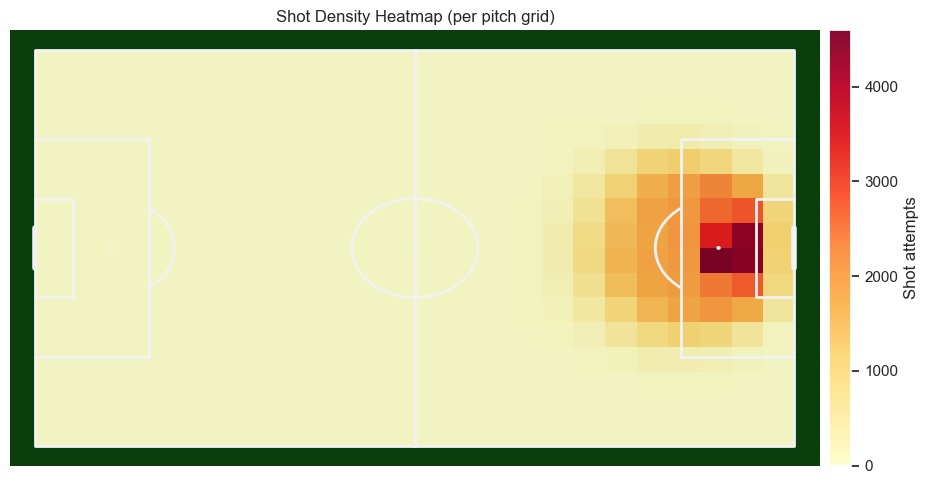

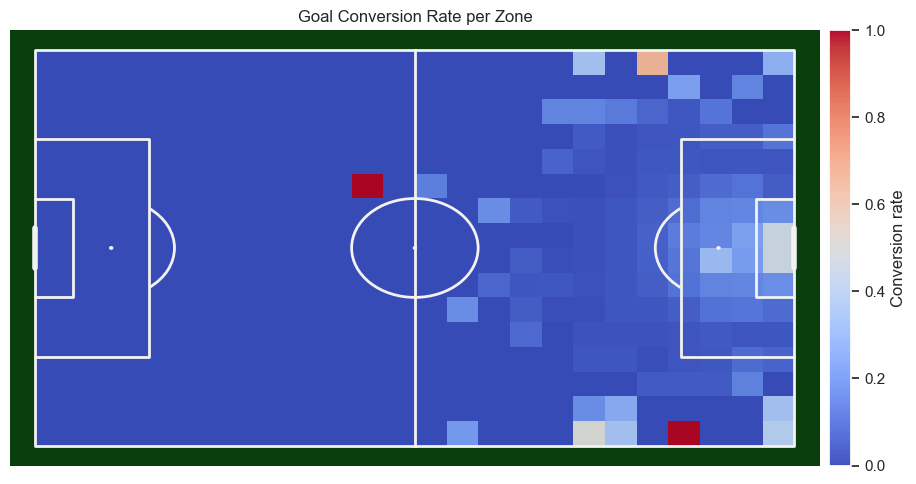

In [ ]:
corr = manifest[['auc', 'accuracy', 'rows']].dropna().corr()
fig_corr, ax_corr = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', ax=ax_corr, cbar_kws={'shrink': 0.8})
ax_corr.set_title('Correlation Between Model Metrics')

x_bins = np.linspace(0, 120, 25)
y_bins = np.linspace(0, 80, 17)
counts, _, _ = np.histogram2d(shots['start_x'], shots['start_y'], bins=[x_bins, y_bins])
goals = shots[shots['is_goal'] == 1]
goal_counts, _, _ = np.histogram2d(goals['start_x'], goals['start_y'], bins=[x_bins, y_bins])
conversion = np.divide(goal_counts, counts, out=np.zeros_like(goal_counts), where=counts > 0)

pitch = Pitch(pitch_length=120, pitch_width=80, pitch_color='#0a3f0d', line_color='#f2f2f2', line_zorder=3, goal_type='box')
extent = (x_bins[0], x_bins[-1], y_bins[0], y_bins[-1])

fig_density, ax_density = pitch.draw(figsize=(10, 5))
density_img = ax_density.imshow(
    counts.T,
    extent=extent,
    origin='lower',
    cmap='YlOrRd',
    alpha=0.9,
    aspect='auto',
    interpolation='bicubic',
    zorder=1,
 )
ax_density.set_xlim(extent[0], extent[1])
ax_density.set_ylim(extent[2], extent[3])
ax_density.set_facecolor('#0a3f0d')
fig_density.colorbar(density_img, ax=ax_density, label='Shot attempts', pad=0.01)
ax_density.set_title('Shot Density Heatmap (per pitch grid)')

fig_conversion, ax_conversion = pitch.draw(figsize=(10, 5))
conversion_img = ax_conversion.imshow(
    conversion.T,
    extent=extent,
    origin='lower',
    cmap='coolwarm',
    alpha=0.9,
    vmin=0,
    vmax=1,
    aspect='auto',
    interpolation='bicubic',
    zorder=1,
 )
ax_conversion.set_xlim(extent[0], extent[1])
ax_conversion.set_ylim(extent[2], extent[3])
ax_conversion.set_facecolor('#0a3f0d')
fig_conversion.colorbar(conversion_img, ax=ax_conversion, label='Conversion rate', pad=0.01)
ax_conversion.set_title('Goal Conversion Rate per Zone')

## Section 4: Save Notebook and Export Visualizations
Persist the figures generated above so they can be shared with teammates or added to documentation.

In [45]:
output_dir = Path('notebook_outputs')
output_dir.mkdir(exist_ok=True)
fig_corr.savefig(output_dir / 'metric_correlation.png', dpi=150, bbox_inches='tight')
fig_density.savefig(output_dir / 'shot_density.png', dpi=150, bbox_inches='tight')
fig_conversion.savefig(output_dir / 'conversion_heatmap.png', dpi=150, bbox_inches='tight')
print(f'Saved figures to {output_dir.resolve()}')

Saved figures to E:\xGcoreAI\notebook_outputs
